In [1]:
#!/usr/bin/env python3

import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")
from multiprocessing import Pool,cpu_count
from functools import partial
from scipy import sparse
from scipy import stats
import pickle
import datetime
import argparse
import logging

import snmcseq_utils
from __init__ import *
from __init__jupyterlab import *

import CEMBA_clst_utils
import fbpca

In [2]:
sys.path.insert(0, "../")
import enhancer_gene_utils

In [3]:
# def create_parser():
#     """
#     """
#     parser = argparse.ArgumentParser()
#     parser.add_argument('-tag', '--input_name_tag', required=True, type=str)
#     parser.add_argument('-modx', '--mod_x', required=True, type=str)
#     parser.add_argument('-mody', '--mod_y', required=True, type=str)

#     parser.add_argument('-knn', '--knn_across', required=True, type=int)
#     parser.add_argument('-ka', '--knn_within', required=True, type=int)
#     parser.add_argument('-dt', '--result_date', type=str, help="eg: 200803")
#     parser.add_argument('-isub', '--i_sub', type=str, help="[0-9]")
#     return parser

11/23/2020 08:58:46 PM corr_analysis_10x_cells_v3_snatac_gene_mop_10x_cells_v3_snatac_gene_ka30_knn2_201120
11/23/2020 08:58:46 PM <class 'numpy.ndarray'>_(69727,)_cell_10x_cells_v3.txt
11/23/2020 08:58:46 PM <class 'numpy.ndarray'>_(135665,)_cell_snatac_gene.txt
11/23/2020 08:58:46 PM <class 'numpy.ndarray'>_(31053,)_gene_10x_cells_v3.txt
11/23/2020 08:58:46 PM <class 'pandas.core.frame.DataFrame'>_(233514, 3)_enh.tsv


2*********


11/23/2020 08:58:49 PM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
11/23/2020 08:58:49 PM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 135665)_mat_snatac_gene.npz


(69727, 34) (69727, 54844) (69727,) (54844,)


11/23/2020 08:59:00 PM (69727, 54844)_(69727, 34)_(31053, 69727)_(233514, 54844)


cluster_n1180
Number of metacells: 1180
(31053, 1180) (233514, 1180)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150994 16776


<ipython-input-4-4f4ecb455468>:200: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-4-4f4ecb455468>:202: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-4-4f4ecb455468>:206: VisibleDeprecationWarning: Passing `normed

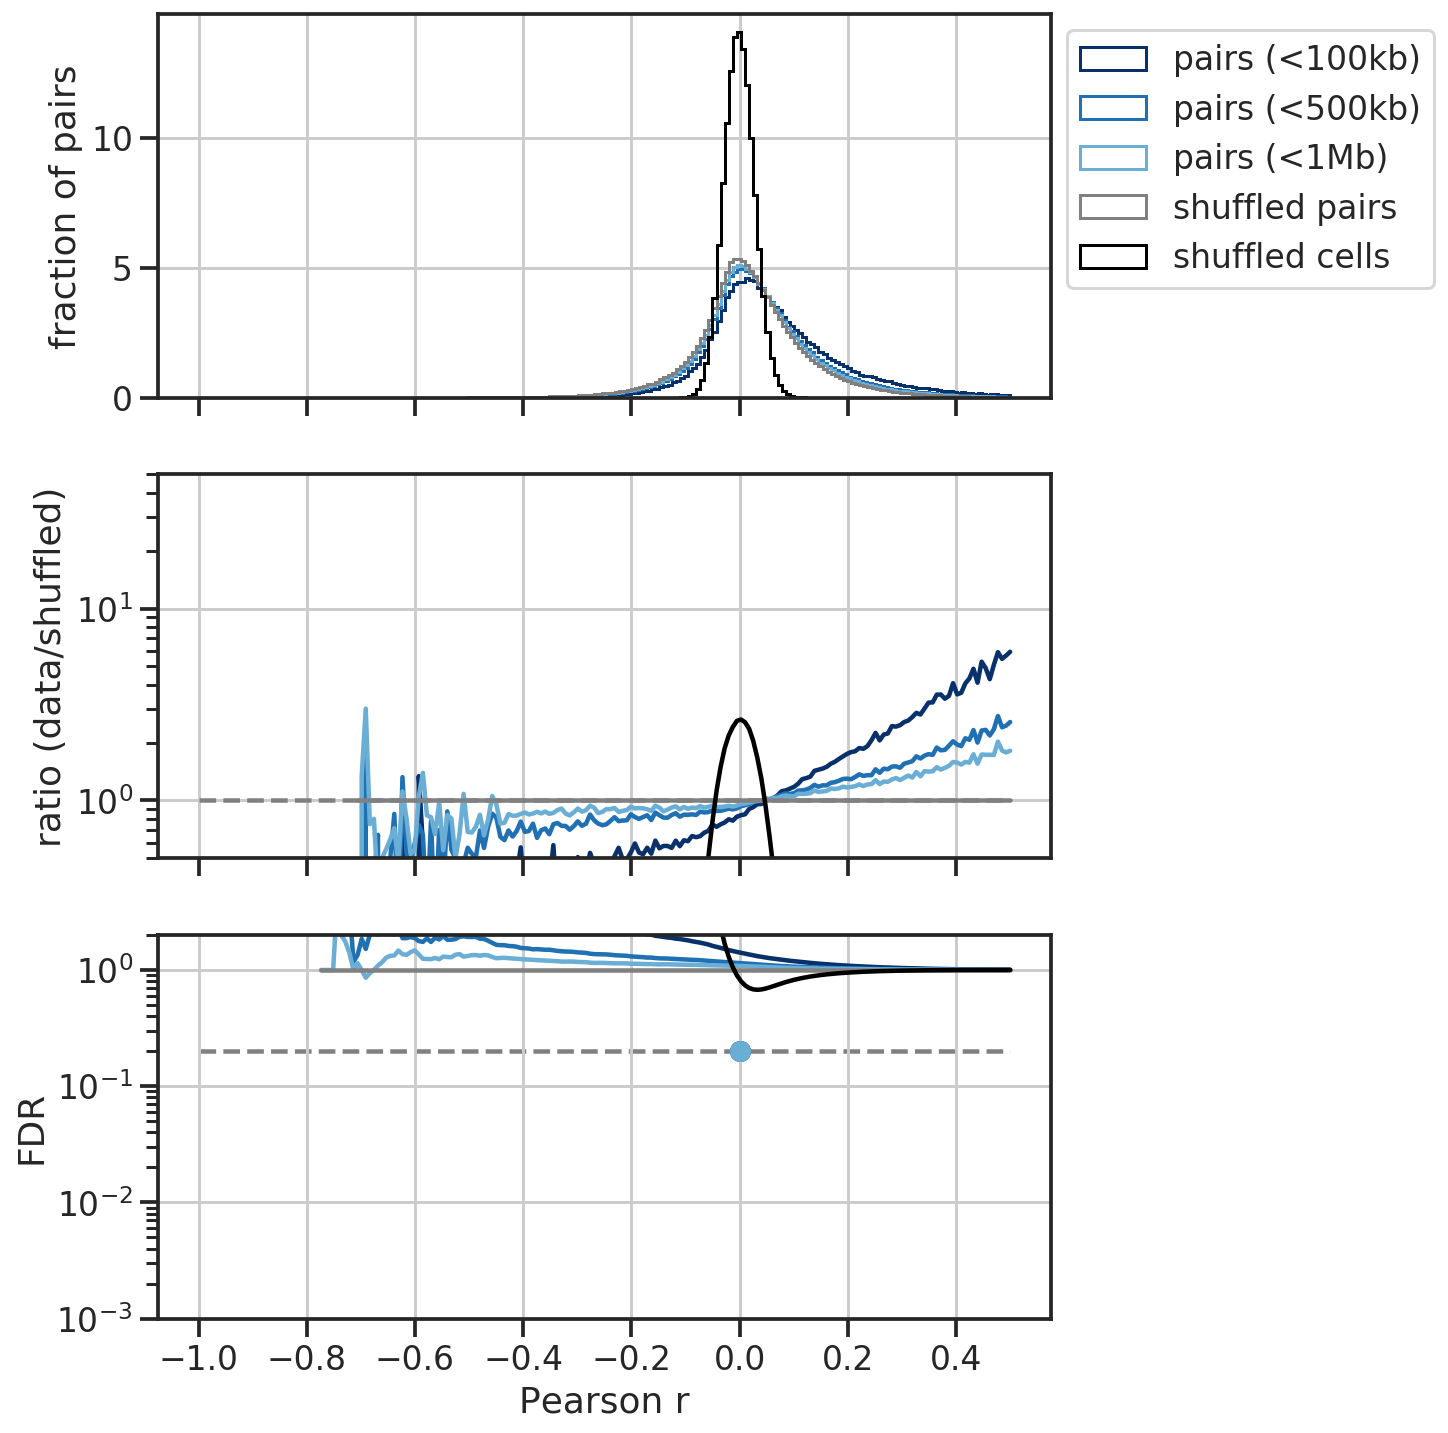

cluster_n1485
Number of metacells: 1485
(31053, 1485) (233514, 1485)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


KeyboardInterrupt: 

In [4]:
logger = snmcseq_utils.create_logger()

# parser = create_parser()
# args = parser.parse_args()

# # set up 
# input_name_tag = args.input_name_tag
# mod_x = args.mod_x
# mod_y = args.mod_y

# knn = args.knn_across 
# ka = args.knn_within 
# result_date = args.result_date
# i_sub = args.i_sub

# set up 
mod_x = '10x_cells_v3'
mod_y = 'snatac_gene'

knns = [2, 5, 10]

for knn in knns:
    print("{}*********".format(knn))
    
    input_name_tag = 'mop_10x_cells_v3_snatac_gene_ka30_knn{}_201120'.format(knn)

    # set up data directories
    name = "corr_analysis_{}_{}_{}".format(mod_x, mod_y, input_name_tag) 
    logging.info(name)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{{}}_corrs.pkl'.format(name)
    output_figures = "/cndd2/fangming/projects/scf_enhancers/results/figures/{}_{{}}.pdf".format(name) 

    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snatac_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_snatac_gene.npz'
    )

    # input knn networks 
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    # for knn_xx
    input_modx_clsts = [
        'clusterings_mop_{}_201123.tsv.gz'.format(mod_x),
        'clusterings_mop_{}_201120.tsv.gz'.format(mod_x), 
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.0.npz'.format(input_name_tag, mod_x, mod_y) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.0.npy'.format(mod_x, input_name_tag)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.0.npy'.format(mod_y, input_name_tag)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_modx_cells, common_mody_cells, 
     common_genes, common_enhancer_regions,
     X, Y, 
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        print(modx_clsts.shape, knn_xy.shape, 
              cell_cell_knn_xaxis.shape, 
              cell_cell_knn_yaxis.shape,
             )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

    # new cells  
    common_modx_cells_updated = np.intersect1d(common_modx_cells, cell_cell_knn_xaxis)
    common_mody_cells_updated = np.intersect1d(common_mody_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_modx_cells, common_modx_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mody_cells, common_mody_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y = Y.tocsc()[:, y_idx]

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_modx_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mody_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_modx_cells_updated)

    # knn_xx = knn_xx.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_xaxis] # x-by-x

    logging.info("{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y.shape,))

    for clst_col in modx_clsts.columns: 
        print(clst_col)

        # choose one clustering to proceed
        uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
        print("Number of metacells: {}".format(len(uniq_labels)))

        knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                            uniq_labels,
                                           )
        # normalization - such that metacells made of more cells still sums to 1
        knn_xz = knn_xz.dot(sparse.diags(np.ravel(1.0/knn_xz.sum(axis=0))))

        # gene by metacell
        gc_rna = X.dot(knn_xz).todense() 

        # enhancer by metacell
        knn_yz = knn_xy.T.dot(knn_xz)
        ec_atac = Y.dot(knn_yz).todense() # normalize ATAC?
        print(gc_rna.shape, ec_atac.shape,)

        # corr analysis
        output_corr = output_corrs.format(clst_col)
        (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
            gc_rna, ec_atac, 
            common_genes, np.arange(len(ec_atac)),
            enhancer_gene_to_eval['gene'].values, 
            enhancer_gene_to_eval['ens'].values, 
            output_file=output_corr, chunksize=100000, verbose_level=0,
            )

        # plotting
        # some basic stats
        dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
        uniq_enh = enhancer_gene_to_eval.loc[to_correlate, 'ens'].unique()
        uniq_gene = enhancer_gene_to_eval.loc[to_correlate, 'gene'].unique()

        print(np.min(dists), np.max(dists))
        print(len(uniq_enh), len(uniq_gene))

        # plotting setup
        num_bins = 200
        bin_min, bin_max = -1, 0.5
        fdr_threshold = 0.2
        bins = np.linspace(bin_min, bin_max, num_bins)

        tracks = {
            'pairs (<100kb)': corrs[dists<1e5], 
            'pairs (<500kb)': corrs[dists<5e5], 
            'pairs (<1Mb)': corrs, 
            'shuffled pairs': corrs_shuffled, 
            'shuffled cells': corrs_shuffled_cells, 
            }

        colors = snmcseq_utils.get_grad_colors(len(tracks), cmap='Blues_r')
        track_colors = {
            'pairs (<100kb)': colors[0], 
            'pairs (<500kb)': colors[1], 
            'pairs (<1Mb)': colors[2], 
            'shuffled pairs': 'gray', 
            'shuffled cells': 'black', 
            }

        config = {
            'kde': False,
            "hist_kws": {
                        'histtype': 'step', 
        #                 'edgecolor': 'none',
                        'alpha': 1, 
                        'density': True, 
                        },
        }

        track_pdf_ratios = {}
        track_cdfs = {}
        track_fdrs = {}

        track_r_thresholds = {}
        track_num_sigs = {}
        track_frac_sigs = {}

        track_r_thresholds_cells = {}
        track_num_sigs_cells = {}
        track_frac_sigs_cells = {}

        hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
        cdf_shuff = np.cumsum(hist_shuff)
        hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
        cdf_shuff_cells = np.cumsum(hist_shuff_cells)
        for label, track in tracks.items():
            # dist
            hist, _ = np.histogram(track, bins=bins, normed=True)
            cdf = np.cumsum(hist)
            # fdr
            fdr = cdf_shuff/cdf
            fdr_cells = cdf_shuff_cells/cdf
            # record
            track_pdf_ratios[label] = hist/hist_shuff
            track_cdfs[label] = cdf 
            track_fdrs[label] = fdr

            if label.startswith("pairs"):
                # get r_threshold
                # remove nan
                isnan = np.isnan(fdr)
                _y = fdr[~isnan]
                _x = bins[1:][~isnan]

                # find r threshold
                try:
                    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
                    r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
                except:
                    r_threshold = 0

                # num and frac significant
                num_sig = np.sum(track < r_threshold)
                frac_sig = num_sig/len(track)

                # record
                track_r_thresholds[label] = r_threshold 
                track_num_sigs[label] = num_sig
                track_frac_sigs[label] = frac_sig

                ## shuff cells
                # get r_threshold
                # remove nan
                isnan = np.isnan(fdr_cells)
                _y = fdr_cells[~isnan]
                _x = bins[1:][~isnan]

                # find r threshold
                try:
                    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
                    r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
                except:
                    r_threshold = 0

                # num and frac significant
                num_sig = np.sum(track < r_threshold)
                frac_sig = num_sig/len(track)

                # record
                track_r_thresholds_cells[label] = r_threshold 
                track_num_sigs_cells[label] = num_sig
                track_frac_sigs_cells[label] = frac_sig


        # figure 2
        fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

        ax = axs[0]
        for label, track in tracks.items():
            sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        ax.set_ylabel('fraction of pairs')
        # ax.set_ylim([0, 6])

        ax = axs[1]
        for label, track in track_pdf_ratios.items():
            ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
        ax.set_yscale('log')
        ax.hlines(1, bins[0], bins[-1], linestyle='--', color='gray')
        ax.set_ylabel('ratio (data/shuffled)')
        ax.set_ylim([0.5, 50])

        ax = axs[2]
        for label, track in track_fdrs.items():
            ax.plot(bins[1:], track, color=track_colors[label])
            if label.startswith('pairs'):
                ax.scatter(track_r_thresholds[label], fdr_threshold, color=track_colors[label])
        ax.hlines(fdr_threshold, bins[0], bins[-1], color='gray', linestyle='--', zorder=0)

        ax.set_yscale('log')
        ax.set_ylabel('FDR')
        ax.set_xlabel('Pearson r')
        ax.set_ylim([1e-3, 2])

        snmcseq_utils.savefig(fig, output_figures.format("corr_dist_plot_"+clst_col))
        plt.show()